Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Sampling large graphs on IPUs using PyTorch Geometric



[![Run on Gradient](../../gradient-badge.svg)](https://console.paperspace.com/github/<runtime-repo>?machine=Free-IPU-POD4&container=<dockerhub-image>&file=<path-to-file-in-repo>)  [![Join our Slack Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

>### Link for the Run on Gradient button

> Once the notebook is available on Paperspace Gradient we like to have a "Run on Gradient" button. The link for the button needs to be configured. The example above shows the convention for how to form the link. 

> - The SVG image file for the button should be a local file in the repo (as shown in the example above). You can also use the [image file on Paperspace](https://assets.paperspace.io/img/gradient-badge.svg) but this is not reliable as Github's caching occasionally breaks.
> - `<runtime-repo>` represents the "organisation/repository-name" of the public repository that contains the notebook.
> - `<dockerhub-image>` is the name and tag of a public Docker Hub container.
> - `<path-to-file-in-repo>` is the location of the notebook inside the repo starting with a leading `/`.
>
> Note the part after the `?` in the link needs to be URL-encoded. You can use an online [URL encoder](https://www.urlencoder.org/) or you can use the [Paperspace link builder](https://docs.paperspace.com/gradient/notebooks/run-on-gradient/).
>
> Example of a fully-formed link for the "Run on Gradient" button:
> https://console.paperspace.com/github/gradient-ai/Graphcore-Pytorch?machine=Free-IPU-POD4&container=graphcore/pytorch-jupyter:3.1.0-ubuntu-20.04-20230104&file=/temporal-graph-networks/Train_TGN.ipynb

In the previous tutorials we have been focusing on working with datasets comprising many small graphs. For some modern applications, however, we will need to operate on larger graphs characterised by increasing number of nodes (range 10M-10B) and edges (range 100M-100B): imagine having to build a recommendation system for a social network type of input graph, which can be consituted by a huge number of users (nodes) and relationships (edges). Mention OGB benchmarks as well? 

We might think of two routes to approach large graph problems:
- full batch training: this is the approach we have been using in [Tutorial 2](TODO add link) when working with a single, relatively small graph. The aim is to generate embeddings for all the nodes at the same time: this entails keeping in memory the entire graph as well as all the node embeddings. If the size of the computational graph increases, the amount of memory required to hold graph and embeddings become challenging. 
- mini-batching: alternatively, we can sample mini-batches from the graph similarly to what we did in Tutorial 3 or 4 [TODO add links] where the dataset was a collection of many small graphs. When sampling from a larger graph, however, we need to be extra careful to reduce the chances of the sampled nodes to be isolated from each other. Should that be the case, the mini-batches would no longer be representative of the whole graph which would negatively impact our machine learning task. The need here is to engineer effective sampling methods to make sure that the message passing scheme is still effective with large graphs. 

In this tutorial, we will demonstrate two approaches widely used in literature to cope with increasing graph size by performing message passage over mini-batches. We will leverage the Graphcore IPU architecture, which is a very good fit for GNNs applications [TODO link blogs], and our PyTorch Geometric (PyG) integration. You will learn how to: 
- effectively cluster nodes of your input graph; 
- sample neighbouring nodes of your input graph; 
- then, for both sampling methods, train your GNN on IPUs to classify papers from the PubMed dataset.

This notebook assumes some familiarity with PopTorch as well as PyTorch Geometric (PyG). For additional resources please consult:
- [PopTorch Documentation](https://docs.graphcore.ai/projects/poptorch-user-guide/en/latest/index.html),
- [PopTorch Examples and Tutorials](https://docs.graphcore.ai/en/latest/examples.html#pytorch),
- [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/),
- [PopTorch Geometric Documentation](https://docs.graphcore.ai/projects/poptorch-geometric-user-guide/en/latest/index.html).

[![Join our Slack
Community](https://img.shields.io/badge/Slack-Join%20Graphcore's%20Community-blue?style=flat-square&logo=slack)](https://www.graphcore.ai/join-community)

In [43]:
# Make imported python modules automatically reload when the files are changed
# needs to be before the first import.
%load_ext autoreload
%autoreload 2
# TODO: remove at the end of notebook development

## Environment setup

The best way to run this demo is on Paperspace Gradient's cloud IPUs because everything is already set up for you. To run the demo using other IPU hardware, you need to have the Poplar SDK enabled and the latest PopTorch Geometric wheel installed. Refer to the [getting started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to enable the Poplar SDK and install the PopTorch wheels.

> You can install requirements directly from a notebook. You can:
>
> 1. Run commands by starting the line in a code cell with `!`, as shown in the first code block below. 
> 2. Install Python requirements with the `%pip` [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html).
> 
> Use these methods to make it easier for your user to set up the environment they need.

In [44]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


To make it easier for you to run this tutorial, we read in some configuration related to the environment you are running the notebook in.

In [45]:
import os

number_of_ipus = int(os.getenv("NUM_AVAILABLE_IPU", 16))
pod_type = os.getenv("GRAPHCORE_POD_TYPE", "pod16")
executable_cache_dir = (
    os.getenv("POPLAR_EXECUTABLE_CACHE_DIR", "/tmp/exe_cache/") 
    + "/pyg-large-graph-sampling"
)
dataset_directory = os.getenv("DATASETS_DIR", "data")
checkpoint_directory = os.getenv("CHECKPOINT_DIR")

> As the notebook writer, you only need to define a variable if you intend to use the value in the rest of the notebook.
> You can choose to use the default values of any variables if it is better for your development workflow.
> When you write the notebook, you need to use those variables that you have defined to configure the execution.
>
> Note on Poplar executables: We also set the standard PyTorch, PopART and TensorFlow environment variables, so
> if you do not customise the behaviour then you don't need to read them from the environment.
> For more information refer to [Writing a Paperspace notebook](https://graphcore.atlassian.net/wiki/spaces/PM/pages/3098345498/Writing+a+Paperspace+notebook).

## Clustering the computation graph for node classification

The idea: we can sample the entire graph in small subgraphs that individually fit in memory and on which we can calculate layer-wise embeddings, performing message passing on one subgraph at the time.
The subgraph should also retain the connectivity of the original graph, to achieve that we make sure that the small communities the original graph is made up of are mirrored in the subgraphs.

A well known approach is [Cluster-GCN](https://arxiv.org/abs/1905.07953). The steps are:
- pre-procesing: given a large graph, we partition it into group of nodes we name subgraphs
- mini-batch training: we load one subgraph at the time in the device memory, apply message passing over it to compute the loss

You can also check out our dedicated Cluster-GCN example (TODO add link)

### Cluster-GCN in PyG on IPUs



First, let's load the `PubMed` dataset from the `Planetoid` node classification benchmarking suite and print some statistics.

In [46]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

transform = T.Compose([T.NormalizeFeatures(), T.AddSelfLoops()])

dataset = Planetoid(root=dataset_directory, name="PubMed", transform=transform)
data = dataset[0]  # Access the graph as Data object

print(f"Dataset: {dataset} ")
print(f"Number of graphs: {len(dataset)}: ")
print(f"Number of features: {dataset.num_features} ")
print(f"Number of classes: {dataset.num_classes} ")

print(data)

print(f"Total number of nodes: {data.num_nodes}")
print(f"Total number of edges: {data.num_edges}")



Dataset: PubMed() 
Number of graphs: 1: 
Number of features: 500 
Number of classes: 3 
Data(x=[19717, 500], edge_index=[2, 108365], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Total number of nodes: 19717
Total number of edges: 108365


The dataset consists of 19717 scientific publications from the PubMed database relative to diabetes classified into one of three classes. This is not a huge dataset, but it will serve our purpose to demonstrate the sampling approaches. 
Let's now proceed with the clustering. The first step is to use `ClusterData` to partition our `Data` object into `num_clusters` clusters: under the hood it leverages the METIS algorithm to obtain the split (TODO add more info on how the METIS algo works?).

In [47]:
from torch_geometric.loader import ClusterData

num_clusters = 100

cluster_data = ClusterData(
    data, num_parts=num_clusters, recursive=False, save_dir=dataset_directory
)

print(f"The dataset has been split in {len(cluster_data)} clusters")

The dataset has been split in 100 clusters


We can now inspect the composition of a couple of clusters, for example:

In [48]:
cluster_data[50], cluster_data[60]

(Data(x=[196, 500], y=[196], train_mask=[196], val_mask=[196], test_mask=[196], edge_index=[2, 626]),
 Data(x=[202, 500], y=[202], train_mask=[202], val_mask=[202], test_mask=[202], edge_index=[2, 706]))

You will observe how each cluster contains a different number of nodes and edges, which we will need to keep in mind when preparing the mini-batches to feed into the IPU. The IPU relies on Ahead-Of-Time compilation hence it needs the input tensors to be fixed sizes. The mini-batches that we will load onto the IPU will be the result of combining clusters together, hence each mini-batch will have a different size.  We need to make sure that the mini-batches are fixed in size so they can be loaded correctly into the IPU. 

We can leverage the `Summary` API in PyG to find out the maximum number of nodes and edges in each cluster:

In [49]:
from torch_geometric.data.summary import Summary

cluster_summary = Summary.from_dataset(cluster_data)
cluster_summary

ClusterData (#graphs=100):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |    197.2 |    803.7 |
| std        |      4.7 |    199.2 |
| min        |    191   |    581   |
| quantile25 |    192.8 |    666.5 |
| median     |    197   |    740   |
| quantile75 |    202   |    858   |
| max        |    203   |   1497   |
+------------+----------+----------+

We can use this information to calculate the maximum number of nodes that we would like to have in each mini-batch, which will also be consistent across mini-batches. To do so we also need to choose how many clusters we'd like to have in each mini-batch (equivalent to choosing a `batch_size` in Tutorial 3), let's set it to 10:

In [50]:
clusters_per_batch = 10 # batch_size

max_num_nodes_per_cluster = int(cluster_summary.num_nodes.max)
max_nodes_per_batch = max_num_nodes_per_cluster * clusters_per_batch + 1

max_nodes_per_batch

2031

Let's keep in mind we will also need to number of edges to be consistent across mini-batches to work with fixed sizes on the IPU: this means we will need to apply some padding to the number of edges. In the code cell above we added one dummy node to the maximum number of nodes in each mini-batch so that we can use it to link all the padded edges to it as self-loops. Now let's calculate the number of edges: we need to approximate it using the average statics printed above, to which we will add its standard deviation.

In [51]:
max_edges_per_batch = int(cluster_summary.num_edges.mean) + int(
    cluster_summary.num_edges.std
)
max_edges_per_batch *= clusters_per_batch
max_edges_per_batch

10020

You might already be familiar with the PyG `ClusterLoader` to implement the stochastic partitioning scheme in CLuster-GCN given a user defined `batch_size` . To comply with the AOT compilation requirement on IPUs we will use instead `FixedSizeClusterLoader` from PopTorch Geometric, where we can specify the number of nodes and edges to be fixed in every mini-batch and equal to the quantities calculated in the previous two cells:

In [52]:
import poptorch
from poptorch_geometric.cluster_loader import FixedSizeClusterLoader

train_dataloader = FixedSizeClusterLoader(
    cluster_data,
    batch_size=clusters_per_batch,
    num_nodes=max_nodes_per_batch,
    collater_args=dict(num_edges=max_edges_per_batch, trim_edges=True),
    num_workers=8,
)

Let's now inspect a few mini-batches loaded by the dataloader:

In [53]:
train_dataloader_iter = iter(train_dataloader)
print(f"{next(train_dataloader_iter) = }")
print(f"{next(train_dataloader_iter) = }")

next(train_dataloader_iter) = DataBatch(x=[2031, 500], edge_index=[2, 10020], y=[2031], batch=[2031], ptr=[3], test_mask=[2031], train_mask=[2031], val_mask=[2031], num_nodes=2031, num_edges=10020)
next(train_dataloader_iter) = DataBatch(x=[2031, 500], edge_index=[2, 10020], y=[2031], batch=[2031], ptr=[3], test_mask=[2031], train_mask=[2031], val_mask=[2031], num_nodes=2031, num_edges=10020)


As expected, we can appreciate how each mini-batch has the same number of nodes and edges that we specified earlier (610 and 3006 respectively). All the tensor shapes are consistent across mini-batches too. Now that we have clustered and loaded the data compatibly with the AOT requirements of the IPU, the next step is to train a GNN model to classify the papers in our dataset.

### Training a GNN to classify papers in the PubMed dataset

The first step is to define a GNN model to carry out our classification task. We can easily re-use one of the models we defined in the previous tutorials, for example a simple GCN-based one:

In [62]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(GCN, self).__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(in_channels, 64, add_self_loops=False)
        self.conv2 = GCNConv(64, out_channels, add_self_loops=False)
        
    def forward(self, x, edge_index, train_mask=None, y=None):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.log_softmax(x, dim=-1)

        if self.training:
            y = torch.where(train_mask, y, -100)
            loss = F.nll_loss(x, y)
            return x, loss
        return x

We can now create the PopTorch model and train it on the IPU:

In [63]:
model = GCN(dataset.num_features, dataset.num_classes)
model


GCN(
  (conv1): GCNConv(500, 64)
  (conv2): GCNConv(64, 3)
)

In [64]:
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)
poptorch_model = poptorch.trainingModel(model, optimizer=optimizer)

Training loop looks like this:

In [67]:
from tqdm import tqdm

num_epochs = 5
train_losses = torch.empty(num_epochs, len(train_dataloader))

for epoch in range(num_epochs):
    bar = tqdm(train_dataloader)
    for i, data in enumerate(bar):
        _, mini_batch_loss = poptorch_model(
            data.x, data.edge_index, data.train_mask, data.y
        )
        train_losses[epoch, i] = float(mini_batch_loss.mean())
        bar.set_description(
            f"Epoch {epoch} training loss: {train_losses[epoch, i].item():0.6f}"
        )
        

Epoch 4 training loss: 0.753350: 100%|██████████| 10/10 [00:00<00:00, 123.87it/s]


We can now detach the training model from the IPU:

In [69]:
poptorch_model.detachFromDevice()

Finally we can plot the mean of the loss to verify it decreases nicely:

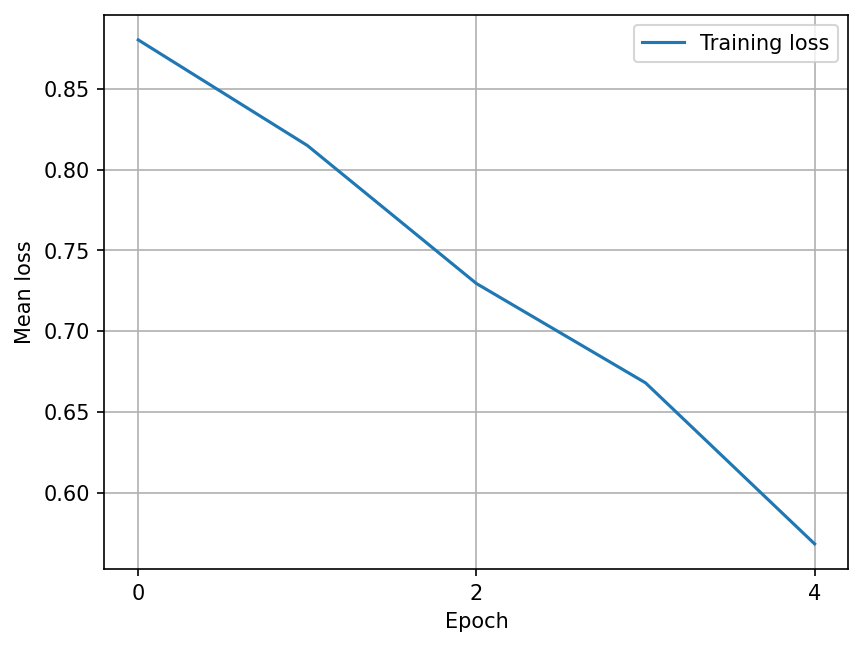

In [70]:
import matplotlib.pyplot as plt

plt.plot(train_losses.mean(dim=1))
plt.xlabel("Epoch")
plt.ylabel("Mean loss")
plt.legend(["Training loss"])
plt.grid(True)
plt.xticks(torch.arange(0, num_epochs, 2))
plt.gcf().set_dpi(150)

## Neighbourhood sampling the computation graph for node classification

Idea: learn how to aggregate node feature information from a node's K-hop neighbourhood, where K is the number of layers of your GNN. This means we need relatively small memory requirements: to generate the embeddings of a node I only need to know the k-hop neighbourhood structure around that node and the relative features, we don't need to store the rest of the graph. In this way, the mini-batches are going to be made of K-hop neighbourhoods. 

Link GraphSAGE paper (TODO add)

### Neighbour sampling in PyG on IPUs 

Notes:
- In PyG one would use the `NeighborLoader`: a data loader that performs neighbour sampling as per the GraphSAGE paper, allowing for mini-batching when full-batch update is not feasible. 
- On the IPU we need to deal with AOT compilation. Adam has an implementation for a `FixedSizeNeighborLoader` I can leverage, with a couple of TODOs to deal with.

### Training a GNN to classify papers in the PubMed dataset

> ### Useful tips and known challenges
>
> #### Working with `argparse` and command line arguments
>
> If you have encountered problems related to `argparse` while writing a notebook, these tips may help you resolve your problem:
> - Try to disentangle your application from any argument parsing logic.
> - Manually create an [`argparse.Namespace`](https://docs.python.org/3/library/argparse.html#argparse.Namespace).
> - Define custom parsing logic in your app to detect when its running in a Jupyter Notebook, for example as shown in the [simple parsing utilities](https://github.com/graphcore/examples-utils/blob/f8673d362fdc7dc77e1fee5f77cbcd81dd9e4a2e/examples_utils/parsing/simple_parsing_tools.py#L118). 
> 
> Often with these kinds of problems, the issue is rooted in the structure of the app, so consider using the [Applications common code interface](https://graphcore.atlassian.net/wiki/spaces/PM/pages/3164995668/Making+applications+notebook+ready+RFC#Proposal) to write an app that is easier to use.
>
> #### Detaching from IPUs
>
> Notebooks continue running after the last cell has been run, so you need to make sure that all IPUs are released at the end. This ensures that other users have resources available to run their notebooks.

In [ ]:
if model.isAttachedToDevice():
    model.detachFromDevice()

AttributeError: 'PoptorchGCN' object has no attribute 'isAttachedToDevice'

## Conclusion

In this tutorial we explored the main methods to deal with large graphs that otherwise wouldn't fit in memory, using two different sampling approaches and dedicated dataloaders to optimise performance on Graphcore IPUs. While we have worked with homogeneous graphs in this tutorial, scaled up GNN problems are also very well suited to heterogeneous graphs (for example, citation graphs can be huge).

TODO add more details about what we covered

> This section should describe the conclusions from this notebook:
>
> - Summarise the main steps that were performed in the demo making it clear what
>  your user got to do. This can be similar to the learning outcomes listed at the beginning of the notebook, but can contain more details. Try to link the specific feature, method or class that was used to achieving a specific outcome. Remember we want to highlight how we can solve the user's problems not sell a feature. (short paragraph: 3-6 sentences)
> - Provide resources for the user's next steps. These can be links to other tutorials, to specific 
>  documentation (for example user guides, tech notes), to code examples in the public Graphcore [examples](https://github.com/graphcore/examples) repo, or to other deployments. (2-4 suggestions)
>
> If you want to link to a notebook in the same runtime, then point the user to the file is rather than using an explicit. For example: "Please see our [name of tutorial] tutorial in `<folder_name>/<notebook_name>.ipynb`. For relative links, the Paperspace platform will download the file locally if the machine is running and if the machine is not running it will throw a 404 error. New windows are opened for full path links.